<a href="https://colab.research.google.com/github/nicholasproietti/LGM/blob/main/CNN_regressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.1 Install lightkurve <a class="anchor" id="first-bullet"></a>

In [1]:
 !pip install lightkurve

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 259 kB 4.4 MB/s 
     |████████████████████████████████| 41 kB 93 kB/s 
     |████████████████████████████████| 4.5 MB 9.0 MB/s 
     |████████████████████████████████| 98 kB 5.1 MB/s 
     |████████████████████████████████| 11.2 MB 27.3 MB/s 
     |████████████████████████████████| 885 kB 52.0 MB/s 
     |████████████████████████████████| 48 kB 5.2 MB/s 
     |████████████████████████████████| 4.0 MB 58.8 MB/s 
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11376 sha256=05841d1e653994f473f62c055f0b0dbd1aeebbe07262ec05a1bb8b96e7104f1a
  Stored in directory: /root/.cache/pip/wheels/b4/3b/77/a06a07a415b222f47a7e522333f85ce64c0defd07a57762267
  Created wheel for memoization: filename=memoization-0.4.0-py3-none-any.whl size=50467 sha256=e2cbc44430e0e1c8c489fbaeaca8c6b5c8d9d4562c811c35688047dc945bb71e
  Stored in directory: /root/.ca

# 1.2 Read KOI table <a class="anchor" id="second-bullet"></a>

In [3]:
# import eleanor
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import lightkurve as lk
import tensorflow as tf
from tensorflow.keras import layers,Input
from tensorflow.keras.models import Model
from keras import optimizers

In [35]:
KOI = pd.read_csv('cumulative_2022.12.07_19.11.18.csv')
KOI

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_insol,koi_model_snr,koi_tce_plnt_num,koi_tce_delivname,koi_steff,koi_slogg,koi_srad,ra,dec,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,93.59,35.8,1.0,q1_q17_dr25_tce,5455.0,4.467,0.927,291.93423,48.141651,15.347
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,9.11,25.8,2.0,q1_q17_dr25_tce,5455.0,4.467,0.927,291.93423,48.141651,15.347
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,...,39.30,76.3,1.0,q1_q17_dr25_tce,5853.0,4.544,0.868,297.00482,48.134129,15.436
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,891.96,505.6,1.0,q1_q17_dr25_tce,5805.0,4.564,0.791,285.53461,48.285210,15.597
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,926.16,40.9,1.0,q1_q17_dr25_tce,6031.0,4.438,1.046,288.75488,48.226200,15.509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,10090151,K07985.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,1,0,...,4500.53,453.3,1.0,q1_q17_dr25_tce,5638.0,4.529,0.903,297.18875,47.093819,14.082
9560,10128825,K07986.01,NaN,CANDIDATE,CANDIDATE,0.497,0,0,0,0,...,1585.81,10.6,1.0,q1_q17_dr25_tce,6119.0,4.444,1.031,286.50937,47.163219,14.757
9561,10147276,K07987.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.021,0,0,1,0,...,5713.41,12.3,1.0,q1_q17_dr25_tce,6173.0,4.447,1.041,294.16489,47.176281,15.385
9562,10155286,K07988.01,NaN,CANDIDATE,CANDIDATE,0.092,0,0,0,0,...,22.68,14.0,1.0,q1_q17_dr25_tce,4989.0,2.992,7.824,296.76288,47.145142,10.998


# 1.3 Download and flatten LC by lightkurve <a class="anchor" id="second-bullet"></a>

In [7]:
maxl = 13000 #maximun length of lc

lc_data=np.zeros((500,maxl))
radii_data=np.zeros((500,1))
num = 0

for ind, row in KOI.iterrows():
  if row['koi_disposition'] != 'CONFIRMED': # only use confirmed cases
    try:
      kepid = str(row['kepid'])
      radius = row['koi_prad']
      if np.isnan(radius):
        continue
      # search and download lc by kepler_id 
      search_result = lk.search_lightcurve(kepid, author='Kepler', cadence='long')
      lc_collection = search_result.download_all()
      lc = lc_collection.stitch().flatten(window_length=901).remove_outliers()
      # read transit parameters from koi table
      planet_b_period = row['koi_period']
      planet_b_t0 = row['koi_time0bk']
      planet_b_dur = row['koi_duration']
      # cut a period of lc from lc_collection
      lc_flux = np.array(lc.fold(planet_b_period, planet_b_t0).flux)
      # convert 3 mins cadence to 30 min cadence (to reduce the array size, otherwise RAM will exceeds when training)
      length_shrink = int(np.floor(len(lc_flux)/10))
      lc_flux = lc_flux[0:length_shrink*10]
      lc_flux[np.isnan(lc_flux)] = 1.0
      lc_shrink = lc_flux.reshape(-1, 10).mean(axis=1)
      #save LC and radius in np array
      lc_data[num, int(maxl/2-np.floor(length_shrink/2)):int(maxl/2+np.ceil(length_shrink/2))] = lc_shrink
      radii_data[num,:] = radius
      num = num +1
      if num >= 500: # download 500 confirmed LCs
        break
      if ind%10 == 0:
        print(ind,num)
    except:
      continue

    

2 1
3 2
8 3
14 4
15 5
16 6
17 7
20 8
24 9
28 10
29 11
30 12
37 13
38 14
40 15
46 16
53 17
58 18
60 19
62 20
63 21
71 22
72 23
75 24
79 25
80 26
83 27
84 28
92 29
93 30
95 31
100 32
101 33
106 34
112 35
117 36
118 37
119 38
122 39
123 40
128 41
129 42
134 43
135 44
136 45
145 46
148 47
162 48
166 49
172 50
176 51
177 52
179 53
184 54
186 55
195 56
196 57
203 58
207 59
213 60
215 61
216 62
225 63
230 64
231 65
236 66
253 67
257 68
267 69
269 70
271 71
273 72
275 73
277 74
279 75
285 76
287 77
288 78
290 79
297 80
304 81
312 82
316 83
318 84
319 85
321 86
322 87
323 88
324 89
325 90
326 91
327 92
328 93
329 94
331 95
332 96
334 97
335 98
338 99
340 100
341 101
342 102
344 103
346 104
347 105
348 106
349 107
351 108
352 109
353 110
357 111
362 112
363 113
364 114
365 115
366 116
367 117
368 118
369 119
370 120
371 121
372 122
373 123
374 124
375 125
384 126
386 127
387 128
388 129
389 130
390 131
392 132
394 133
398 134
399 135
400 136
401 137
402 138
405 139
406 140
407 141
409 142
415 14

458 166
459 167
460 168
461 169
462 170
463 171
464 172
465 173
466 174
469 175
472 176
473 177
474 178
475 179
480 180
483 181
486 182
489 183
490 184
492 185
494 186
500 187
503 188
504 189
506 190
508 191
510 192
511 193
512 194
513 195
514 196
517 197
524 198
526 199
527 200
529 201
534 202
536 203
537 204
539 205
541 206
544 207
545 208
546 209
547 210
550 211
551 212
552 213
553 214
563 215
565 216
569 217
571 218
574 219
575 220
578 221
580 222
581 223
582 224
583 225
584 226
591 227
592 228
594 229
597 230
600 231
601 232
602 233
603 234
604 235
613 236
614 237
619 238
621 239
622 240
623 241
631 242
633 243
634 244
635 245
636 246
637 247
638 248
639 249
640 250
641 251
643 252
647 253
651 254
654 255
656 256
657 257
658 258
659 259
660 260
661 261
662 262
663 263
666 264
668 265
670 266
675 267
676 268
694 269
696 270
697 271
699 272
709 273
716 274
717 275
718 276
719 277
720 278
721 279
726 280
731 281
732 282
737 283
738 284
740 285
741 286
742 287
744 288
748 289
751 290


/usr/local/lib/python3.8/dist-packages/lightkurve/lightcurve.py:1127: LightkurveWarning: The light curve appears to be zero-centered (median=7.55e+04 electron / s +/- 3.49e+05 electron / s); `normalize()` will divide the light curve by a value close to zero, which is probably not what you want.
  warnings.warn(


923 374
924 375
925 376
935 377
936 378
937 379
939 380
940 381
941 382
942 383
943 384
944 385
945 386
946 387
947 388
951 389
952 390
954 391
955 392
956 393
957 394
958 395
959 396
962 397
963 398
966 399
967 400
968 401
971 402
972 403
974 404
975 405
976 406
980 407
981 408
982 409
983 410
984 411
985 412
991 413
992 414
993 415
995 416
1005 417
1010 418
1014 419
1015 420
1016 421
1024 422
1026 423
1033 424
1042 425
1046 426
1047 427
1048 428
1049 429
1050 430
1051 431
1052 432
1055 433
1062 434
1063 435
1065 436
1067 437
1068 438
1073 439
1076 440
1078 441
1080 442
1082 443
1083 444
1085 445
1087 446
1088 447
1091 448
1092 449
1103 450
1106 451
1111 452
1114 453
1117 454
1121 455
1122 456
1123 457
1124 458
1125 459
1127 460
1129 461
1131 462
1132 463
1133 464
1136 465
1139 466
1141 467
1143 468
1144 469
1147 470
1154 471
1155 472
1159 473
1162 474
1165 475
1166 476
1174 477
1176 478
1177 479
1180 480
1182 481
1189 482
1190 483
1193 484
1194 485
1196 486
1201 487
1202 488
1203 489

# 1.4 Save training data <a class="anchor" id="second-bullet"></a>

In [34]:
np.savetxt("lc_data (1).csv", lc_data, delimiter=",")
np.savetxt("radii_data (1).csv", radii_data, delimiter=",")

# 2.1 Download training data <a class="anchor" id="second-bullet"></a>
when restart the program, start from here

In [8]:
lc_data = np.genfromtxt('lc_data (1).csv', delimiter=',')
radii_data = np.genfromtxt('radii_data (1).csv', delimiter=',')

# 2.2 Remove NaN values <a class="anchor" id="second-bullet"></a>

In [10]:
# found some radius are nan, remove them, and store data in lc_data_2
maxl = 13000 #maximun length of lc
lc_data_2=np.zeros((500,maxl))
radii_data_2=np.zeros((500,1))
kk=0
for i in range(len(lc_data)):
  if (radii_data[i] < 100):
    lc_data_2[kk] = lc_data[i]
    radii_data_2[kk] = radii_data[i]
    kk = kk + 1

In [11]:
print(tf.__version__)
gpus = tf.config.list_physical_devices(device_type='GPU')

2.9.2


# 2.3 Split training/ test data <a class="anchor" id="second-bullet"></a>

In [12]:
# min_max sacle radius data and split train/test data
#radii_data_2 = (radii_data_2 - radii_data_2.min(axis=0)) / (radii_data_2.max(axis=0) - radii_data_2.min(axis=0))
x_train = lc_data_2[0:400,:]
y_train = radii_data_2[0:400]
x_test = lc_data_2[401:470]
y_test = radii_data_2[401:470]

# 2.4 Define CNN model <a class="anchor" id="second-bullet"></a>

In [13]:
def built_model():
    INPUT = Input(shape=(13000,1))
    x = layers.Bidirectional(layers.LSTM(128,dropout=0.2))(INPUT)#LSTM
    x  = layers.Conv1D(32,3,activation = 'relu')(INPUT)
    x = layers.AveragePooling1D()(x)
    x  = layers.Conv1D(64,3,activation = 'relu')(x)
    x = layers.AveragePooling1D()(x)
    x  = layers.Conv1D(128,3,activation = 'relu')(x)
    x = layers.MaxPooling1D()(x)
    x = layers.Flatten()(x)

    y = layers.Dense(256,activation = 'relu')(x)
    y = layers.Dense(1)(y)
    model = Model(INPUT, y)
    return model

model = built_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13000, 1)]        0         
                                                                 
 conv1d (Conv1D)             (None, 12998, 32)         128       
                                                                 
 average_pooling1d (AverageP  (None, 6499, 32)         0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 6497, 64)          6208      
                                                                 
 average_pooling1d_1 (Averag  (None, 3248, 64)         0         
 ePooling1D)                                                     
                                                                 
 conv1d_2 (Conv1D)           (None, 3246, 128)         24704 

# 2.5 Complile and run model <a class="anchor" id="second-bullet"></a>

Epoch 1/100
4/4 [==============================] - 27s 4s/step - loss: 652.7510 - mae: 19.8480
Epoch 2/100
4/4 [==============================] - 19s 5s/step - loss: 400.8035 - mae: 14.4703
Epoch 3/100
4/4 [==============================] - 15s 3s/step - loss: 391.2500 - mae: 14.4464
Epoch 4/100
4/4 [==============================] - 15s 3s/step - loss: 443.1207 - mae: 17.7045
Epoch 5/100
4/4 [==============================] - 15s 3s/step - loss: 371.6093 - mae: 14.9710
Epoch 6/100
4/4 [==============================] - 17s 4s/step - loss: 397.8768 - mae: 14.5017
Epoch 7/100
4/4 [==============================] - 17s 4s/step - loss: 379.8582 - mae: 14.5990
Epoch 8/100
4/4 [==============================] - 15s 3s/step - loss: 364.3751 - mae: 15.0430
Epoch 9/100
4/4 [==============================] - 15s 3s/step - loss: 367.9869 - mae: 14.6604
Epoch 10/100
4/4 [==============================] - 15s 3s/step - loss: 369.5332 - mae: 15.0215
Epoch 11/100
4/4 [==============================]

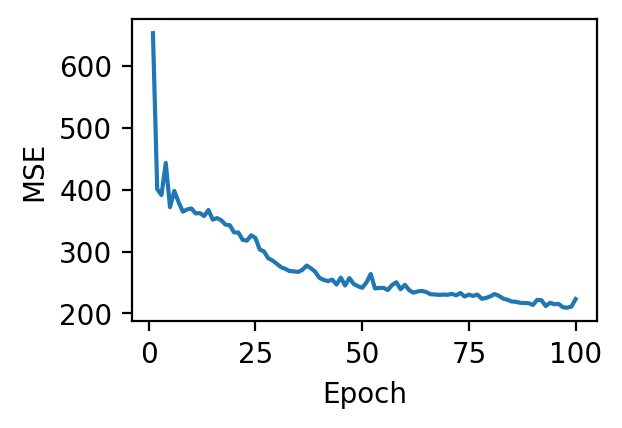

In [14]:
model.compile(loss='mse', optimizer='Adam', metrics=['mae'])
history = model.fit(x_train, y_train, batch_size=128,epochs=100, verbose=1)

# 2.6 Plot Loss and predict values <a class="anchor" id="second-bullet"></a>

3/3 [==============================] - 1s 248ms/step - loss: 373.8252 - mae: 15.6617
loss: 373.8251953125
mae: 15.661652565002441


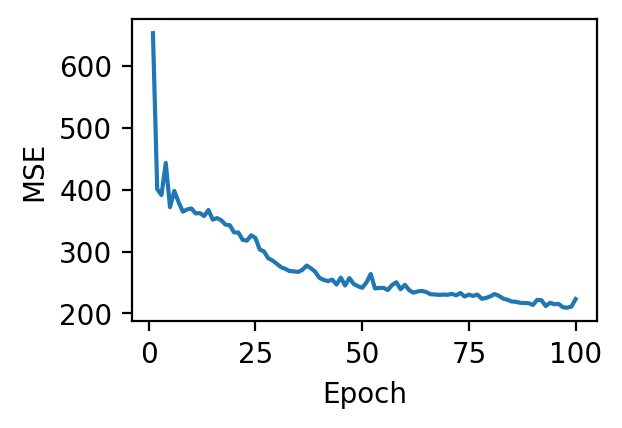

In [15]:
test_mse_score, test_mae_score = model.evaluate(x_test, y_test)
print('loss:',test_mse_score)
print('mae:',test_mae_score)
plt.figure(figsize=(3,2),dpi=200)
epoch_range = range(1, 100+1)
plt.plot(epoch_range,history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

3/3 [==============================] - 1s 229ms/step


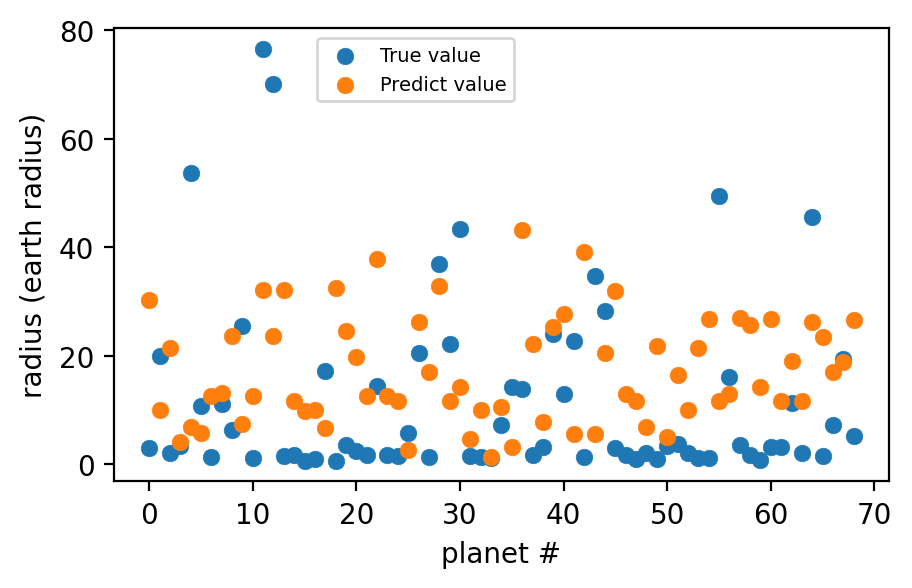

In [33]:
y_test_predict = model.predict(x_test)
plt.figure(figsize=(5,3),dpi=200)
plt.scatter(range(69),y_test,linewidths=0.2, label = 'True value')
plt.scatter(range(69),y_test_predict,linewidths=0.2, label = 'Predict value')
plt.legend(bbox_to_anchor=(0.25,1),fontsize=7)
plt.xlabel("planet #")
plt.ylabel("radius (earth radius)")
plt.show()